In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
from numpy.linalg import det
import pandas as pd
import datetime as dt
import cython
%load_ext Cython



# Kalman filter

Based on Durbin Koopman


For generic state-space systems like (Hamilton's notation):



$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times p)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$




Where

* $p$ is the number of observed variables
* $m$ is the number of latent states
* $r$ is the number of disturbances (?)

In [2]:
class KalmanFilter():
    #     """
    #         Based on Durbin Koopman


    #         For generic state-space systems like (Hamilton's notation):



    #         $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

    #         $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
    #         \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


    #         $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

    #         Where

    #         * $p$ is the number of observed variables
    #         * $m$ is the number of latent states
    #         * $r$ is the number of disturbances

    #     """

    def __init__(self, y, Z, H, T, Q, a1, P1, R):
        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        self.yhat = []
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T  # To avoid transposing it several times
        self.R = np.array(R)

    def runFilter(self, ):
        # Implemented with non time varying coefficients

        for i in range(0, self.n - 1):
            #         for i in range(0,1):
            #             print(self.y[i].shape)
            #             print(self.Z.shape)
            #             print(self.a[i].shape)

            self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

            self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

            Finv = inv(self.Ft[i])

            #             print(self.P[i].shape)
            #             print(self.ZT.shape)
            #             print(Finv.shape)
            #             print(self.vt[i].shape)
            self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

            self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

            self.a.append(self.T.dot(self.a[i]))

            self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

            self.yhat.append(self.Z.dot(self.a[i]))

        self.a = pd.DataFrame(np.concatenate(self.a, axis=1)).T
        self.yhat = pd.DataFrame(np.concatenate(self.yhat, axis=1)).T

# Pandas or numpy dot product ?

In [3]:
df = {
    dt.datetime(2017,1,1) : np.random.randn(4),
    dt.datetime(2017,1,2) : np.random.randn(4),
    dt.datetime(2017,1,3) : np.random.randn(4),
    dt.datetime(2017,1,4) : np.random.randn(4),
}

In [4]:
df = pd.DataFrame(df).T
df

,0,1,2,3
2017-01-01,0.745134,-1.094507,-0.625374,0.737582
2017-01-02,-1.648659,-1.139046,1.396983,-1.295993
2017-01-03,0.842575,2.144121,1.127765,-1.219462
2017-01-04,0.376546,-0.717490,1.604107,1.109635


In [5]:
dfnp = np.array(df)
dfnp

array([[ 0.74513431, -1.0945074 , -0.62537426,  0.73758175],
       [-1.64865925, -1.13904611,  1.39698311, -1.2959929 ],
       [ 0.84257522,  2.14412112,  1.12776533, -1.21946152],
       [ 0.37654635, -0.71748952,  1.60410717,  1.10963522]])

In [6]:
%%timeit -n 1

df.dot(df.T)


The slowest run took 11.72 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 397 µs per loop


In [7]:
%%timeit -n 1

np.dot(dfnp,dfnp.T)

The slowest run took 23.12 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 3.28 µs per loop


Numpy as WAY faster

# Numpy or python append?

Which one is faster to append new values and access the last one

In [8]:
lis = [1.756756,2.123123,3.24234]
nplis = np.array(lis)

In [9]:
%%timeit -n 1

lis.append(7.21342)

lis[-1] + 3.46785

The slowest run took 4.00 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 410 ns per loop


In [10]:
%%timeit -n 1
np.append(nplis,7)
nplis[-1] + 3.46785

The slowest run took 6.69 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 6.56 µs per loop


Python append is way faster

# Dummy data for the KF with non time-varying parameters

For convenience: 

$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

## Local Level model

$$ y_t = \mu_t + \epsilon_t, \qquad \epsilon \sim NID(0, \sigma^2_ \epsilon) $$
$$ \mu_{t+1} = \mu_t + \eta_t, \qquad \eta_t \sim NID(0,\sigma^2_ \eta) $$

In [11]:
m = 2
p = 4


Z = [[0.3,0.7],[0.1,0],[0.5,0.5],[0,0.3]]


Z = pd.DataFrame(Z)

H = pd.DataFrame(np.diag([1.0,2.0,3.0,4.0]))


T = pd.DataFrame(np.identity(2))
R = pd.DataFrame(np.identity(2))

Q = pd.DataFrame(np.diag([0.2,0.4]))

In [12]:
n = 10000 #sample size
mut = [np.array([1,10]).reshape(m,1)]
yt = [np.array([0,0,0,0]).reshape(p,1)]

for i in range(0,1000):
    
    temp = np.multiply(np.random.randn(m,1),np.diag(Q).reshape((m,1)))
    temp = R.dot(temp)
    temp = temp + mut[i]
    mut.append(temp)  
    
    temp = np.multiply(np.random.randn(p,1),np.diag(H).reshape((p,1)))
    yt.append(temp+Z.dot(mut[i+1]))

    
yt[0] = pd.DataFrame(yt[0])   
y = pd.concat(yt,axis=1).T.reset_index(drop=True)
mut[0] = pd.DataFrame(mut[0])
mut = pd.concat(mut,axis=1).T.reset_index(drop=True)

In [13]:
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

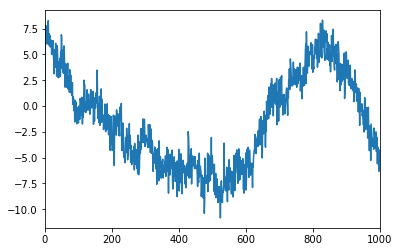

In [14]:
y[0].plot()

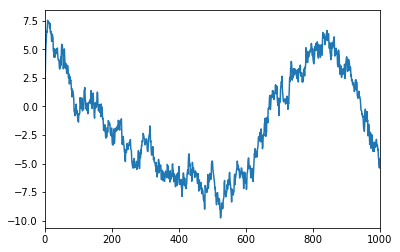

In [15]:
kf.yhat[0].plot()

## Timing the filter with and without Cython

In [16]:
%%timeit -n 1
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

1 loop, best of 3: 151 ms per loop


In [17]:
# import pyximport; pyximport.install()
# import KalmanFilter1

In [18]:
# %%timeit -n 50
# # COMPILED WITH CYTHON

# kf = KalmanFilter1.KalmanFilter(y,
#                   Z,
#                   H,
#                   T,
#                   Q,
#                   pd.DataFrame(np.array([0,0]).reshape(m,1)),
#                   pd.DataFrame(np.diag(np.array([1,1]))),
#                   R)

# kf.runFilter()

# Implementation for nulls

## Faster way to check for nulls Pandas or Numpy

In [19]:
ynp = np.array(y)

In [20]:
%%timeit -n 1
y.isnull().any(axis=1)

1 loop, best of 3: 332 µs per loop


In [21]:
%%timeit -n 1
np.isnan(ynp).any(axis=1)

The slowest run took 6.21 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 7.79 µs per loop


In [22]:
%%timeit -n 1
y.isnull().all(axis=1)

1 loop, best of 3: 276 µs per loop


In [23]:
%%timeit -n 1
np.isnan(ynp).all(axis=1)

The slowest run took 6.88 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 6.97 µs per loop


## Timing Implemention for whole line of nulls

In [24]:
class KalmanFilter():
#         """
#             Based on Durbin Koopman


#             For generic state-space systems like (Hamilton's notation):



#             $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

#             $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
#             \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


#             $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

#             Where

#             * $p$ is the number of observed variables
#             * $m$ is the number of latent states
#             * $r$ is the number of disturbances

#         """

    def __init__(self, y, Z, H, T, Q, a1, P1, R):
  
        
        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        
        ind = np.zeros(self.y.shape[0])
        ind[np.isnan(self.y).any(axis=1)] = 1 # Some NaNs
        ind[np.isnan(self.y).all(axis=1)] = 2 # All NaNs
        self.ind = ind  
        
        self.yhat = []
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T  # To avoid transposing it several times
        self.R = np.array(R)
        

    def runFilter(self, ):
        # Implemented with non time varying coefficients
        
        for i in range(0, self.n - 1):

            if self.ind[i] == 0:

                self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

                Finv = inv(self.Ft[i])

                self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

                self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

                self.yhat.append(self.Z.dot(self.a[i]))
            
            elif self.ind[i] == 2: # In case the line is all nans
            
                self.vt.append(np.zeros((p,1)))
#                 self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

#                 Finv = inv(self.Ft[i])

#                 self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

#                 self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))
                
                self.yhat.append(self.Z.dot(self.a[i]))  
            
        self.a = pd.DataFrame(np.concatenate(self.a, axis=1)).T
        self.yhat = pd.DataFrame(np.concatenate(self.yhat, axis=1)).T

In [25]:
y.loc[20] = np.nan

In [26]:
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

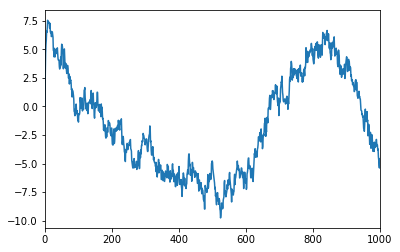

In [27]:
kf.yhat[0].plot()

In [28]:
# with many nulls
ny = y.copy()
ny.iloc[200:700] = np.nan

In [29]:
kf = KalmanFilter(ny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

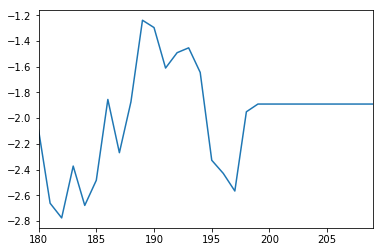

In [30]:
kf.yhat[0].iloc[180:210].plot()

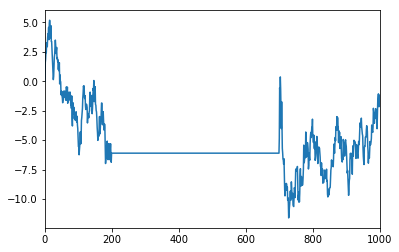

In [31]:
kf.a[0].plot()

In [32]:
%%timeit -n 1

kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

1 loop, best of 3: 150 ms per loop


In [33]:
%%timeit -n 1

kf = KalmanFilter(ny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

1 loop, best of 3: 98.5 ms per loop


## Timing Implemention for partial line of nulls

### Fastest way to flat out 

In [34]:
yt = np.array([1,2,4,np.nan,5,6,7,np.nan,np.nan,8]).reshape((10,1))

In [35]:
yt[~np.isnan(yt)]

array([ 1.,  2.,  4.,  5.,  6.,  7.,  8.])

In [36]:
%%timeit -n 1

~np.isnan(yt).reshape((10))

The slowest run took 8.00 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 2.87 µs per loop


In [37]:
%%timeit -n 1

np.array((~np.isnan(yt)).flat)

The slowest run took 5.18 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 6.97 µs per loop


In [38]:
%%timeit -n 1

(~np.isnan(yt)).ravel()

The slowest run took 10.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 1.64 µs per loop


In [39]:
%%timeit -n 1

(~np.isnan(yt)).flatten()

The slowest run took 6.78 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 3.69 µs per loop


In [40]:

class KalmanFilter():
    #         """
    #             Based on Durbin Koopman


    #             For generic state-space systems like (Hamilton's notation):



    #             $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

    #             $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
    #             \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


    #             $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

    #             Where

    #             * $p$ is the number of observed variables
    #             * $m$ is the number of latent states
    #             * $r$ is the number of disturbances

    #         """

    def __init__(self, y, Z, H, T, Q, a1, P1, R, nStates, performChecks = True):

        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        self.m = nStates

        # Checks
        if performChecks:
            if Z.shape != (self.p,self.m):
                print('Wrong shape for Z')

            if a1.shape != (self.m, 1):
                print('Wrong shape for a1')

            if H.shape != (self.p, self.p):
                print('Wrong shape for H')

            if T.shape != (self.m, self.m):
                print('Wrong shape for T')

            if P1.shape != (self.m, self.m):
                print('Wrong shape for P1')

        ind = np.zeros(self.y.shape[0])
        ind[np.isnan(self.y).any(axis=1)] = 1  # Some NaNs
        ind[np.isnan(self.y).all(axis=1)] = 2  # All NaNs
        self.ind = ind

        self.yhat = []
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T  # To avoid transposing it several times
        self.TT = self.T.T  # To avoid transposing it several times
        self.R = np.array(R)
        self.RT = self.R.T
        self.ranFilter = False

    def runFilter(self, ):
        # Implemented with non time varying coefficients

        for i in range(0, self.n - 1):

            if self.ind[i] == 0:

                self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

                Finv = inv(self.Ft[i])

                self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

                self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.TT) + self.R.dot(self.Q).dot(self.RT))

                self.yhat.append(self.Z.dot(self.a[i]))

            elif self.ind[i] == 2:  # In case the line is all nans

                self.vt.append(np.zeros((p, 1)))
                #                 self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

                #                 Finv = inv(self.Ft[i])

                #                 self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

                #                 self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.TT) + self.R.dot(self.Q).dot(self.RT))

                self.yhat.append(self.Z.dot(self.a[i]))

            else:
                # First use an index for nulls
                ind = ~np.isnan(self.y[i]).ravel()
                yst = self.y[i][ind]
                Zst = self.Z[ind, :]
                ZstT = Zst.T

                select = np.diag(ind)
                select = select[(select == True).any(axis=1)].astype(int)

                Hst = select.dot(self.H).dot(select.T)

                self.vt.append(yst.reshape((yst.shape[0], 1)) - np.dot(Zst, self.a[i]))

                self.Ft.append(Zst.dot(self.P[i]).dot(ZstT) + Hst)

                Finv = inv(self.Ft[i])

                self.a[i] = self.a[i] + self.P[i].dot(ZstT).dot(Finv).dot(self.vt[i])

                self.P[i] = self.P[i] - self.P[i].dot(ZstT).dot(Finv).dot(Zst).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.TT) + self.R.dot(self.Q).dot(self.RT))

                yhat = np.empty((self.p, 1))
                yhat[ind, :] = Zst.dot(self.a[i])
                yhat[~ind, :] = self.Z.dot(self.a[i])[~ind, :]

                self.yhat.append(yhat)

        self.a = pd.DataFrame(np.concatenate(self.a, axis=1)).T
        self.yhat = pd.DataFrame(np.concatenate(self.yhat, axis=1)).T
        self.y = pd.DataFrame(self.y)

        self.ranFilter = True



    def likelihood(self):
        if not self.ranFilter:
            self.runFilter()

        ll = 0
        for i in range(0, self.n - 1):
            ll += np.log(det(self.Ft[i])) +  self.vt[i].T.dot(inv(self.Ft[i])).dot(self.vt[i])
        ll = -n*p*0.5 * np.log(2*np.pi) - 0.5 * ll
        self.ll = ll
        return ll



In [41]:
nny = y
probNan= 0.20
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan
    
    

In [42]:
kf = KalmanFilter(nny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                  nStates=2
                 )

kf.runFilter()

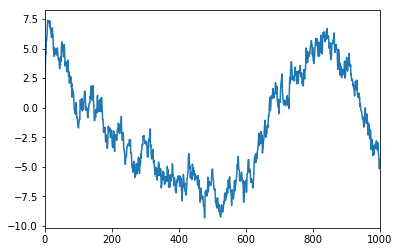

In [43]:
kf.yhat[0].plot()

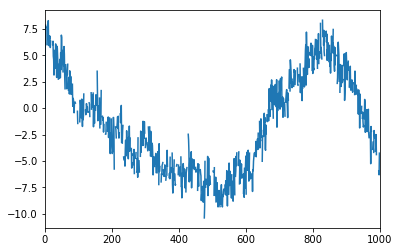

In [44]:
kf.y[0].plot()

### For different NaN probabilities 

In [45]:
nny = y
probNan= 0.0
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan

In [46]:
%%timeit -n 1

kf = KalmanFilter(nny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf.runFilter()

1 loop, best of 3: 123 ms per loop


In [47]:
nny = y
probNan= 0.10
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan

In [48]:
%%timeit -n 1

kf = KalmanFilter(nny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf.runFilter()

1 loop, best of 3: 112 ms per loop


In [49]:
nny = y
probNan= 0.30
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan

In [50]:
%%timeit

kf = KalmanFilter(nny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf.runFilter()

10 loops, best of 3: 96 ms per loop


In [51]:
nny = y
probNan= 0.50
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan

In [52]:
%%timeit

kf = KalmanFilter(nny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf.runFilter()

10 loops, best of 3: 84.6 ms per loop


In [53]:
nny = y
probNan= 0.80
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan

In [54]:
%%timeit

kf = KalmanFilter(nny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf.runFilter()

10 loops, best of 3: 64.5 ms per loop


# Testing the univariate Kalman Filter

In [55]:
n = 1000 #sample size
mut = [np.array([1,10]).reshape(m,1)]
yt = [np.array([0,0,0,0]).reshape(p,1)]

for i in range(0,1000):
    
    temp = np.multiply(np.random.randn(m,1),np.diag(Q).reshape((m,1)))
    temp = R.dot(temp)
    temp = temp + mut[i]
    mut.append(temp)  
    
    temp = np.multiply(np.random.randn(p,1),np.diag(H).reshape((p,1)))
    yt.append(temp+Z.dot(mut[i+1]))

    
yt[0] = pd.DataFrame(yt[0])   
y = pd.concat(yt,axis=1).T.reset_index(drop=True)
mut[0] = pd.DataFrame(mut[0])
mut = pd.concat(mut,axis=1).T.reset_index(drop=True)

In [56]:
# %%timeit
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf.runFilter()

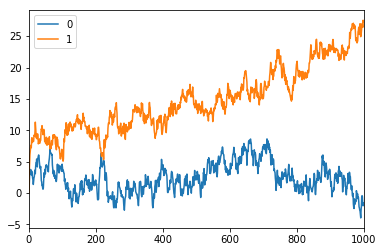

In [57]:
kf.a.plot()

In [58]:
from KalmanFilter_Uni import KalmanFilter as KFU

In [59]:
# %%timeit
kf2 = KFU(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf2.runFilter()

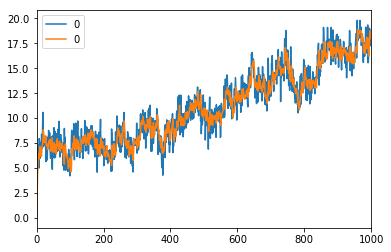

In [60]:
pd.concat([kf2.y[0],kf2.yhat[0],],axis=1).plot()

## Testing for nans

In [61]:
nny = y
probNan= 0.30
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan

In [62]:
# Check if there's any line full of nulls
nny.isnull().all(axis=1).any()

True

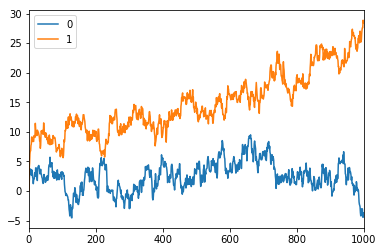

In [63]:
# %%timeit
kf = KalmanFilter(nny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf.runFilter()
kf.a.plot()

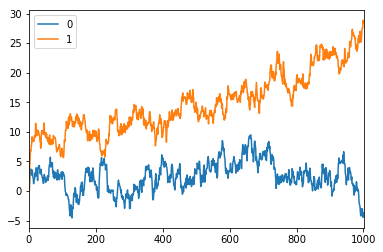

In [64]:
# %%timeit
kf2 = KFU(nny,
              Z,
              H,
              T,
              Q,
              pd.DataFrame(np.array([0,0]).reshape(m,1)),
              pd.DataFrame(np.diag(np.array([1,1]))),
              R,
             nStates=2)

kf2.runFilter()
kf2.states.plot()

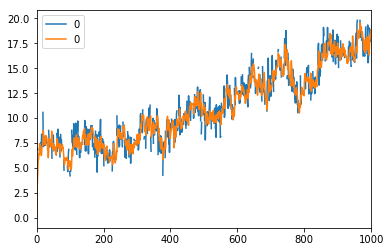

In [65]:
pd.concat([kf2.y[0],kf2.yhat[0],],axis=1).plot()

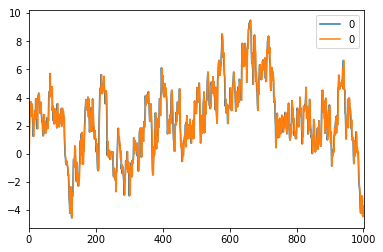

In [66]:
pd.concat([kf.a[0],kf2.states[0],],axis=1).plot()

In [67]:
(kf.a[0] - kf2.states[0]).describe()

count    1001.000000
mean       -0.003685
std         0.735079
min        -2.244220
25%        -0.463015
50%        -0.007517
75%         0.420476
max         2.610309
Name: 0, dtype: float64

In [68]:
from KFUC import KFUC

In [69]:
kf3 = KFUC(y=np.array(nny),
              Z=np.array(Z),
              H=np.array(H),
              T=np.array(T),
              Q=np.array(Q),
              a1=np.array(pd.DataFrame(np.array([0.0,0.0]).reshape(m,1))),
              P1=np.diag(np.array([1.0,1.0])),
              R=np.array(R),
             nStates=2)

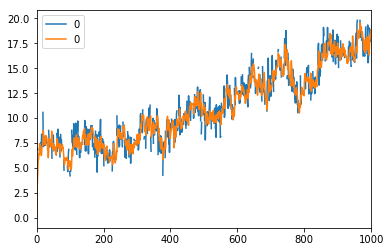

In [70]:
pd.concat([pd.DataFrame(kf3['y'])[0]
           ,pd.DataFrame(kf3['yhat'])[0]
          ],axis=1).plot()

# Final Optimization test 

## Missing Data

In [71]:
%%timeit
kf = KalmanFilter(nny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf.runFilter()

10 loops, best of 3: 118 ms per loop


In [72]:
%%timeit
kf2 = KFU(nny,
              Z,
              H,
              T,
              Q,
              pd.DataFrame(np.array([0,0]).reshape(m,1)),
              pd.DataFrame(np.diag(np.array([1,1]))),
              R,
             nStates=2,export=False)

kf2.runFilter()

10 loops, best of 3: 104 ms per loop


In [73]:
from KalmanFilter_UniCy import KalmanFilter as KFUC1

In [74]:
%%timeit
kf2 = KFUC1(nny,
              Z,
              H,
              T,
              Q,
              pd.DataFrame(np.array([0,0]).reshape(m,1)),
              pd.DataFrame(np.diag(np.array([1,1]))),
              R,
             nStates=2,export=False)

kf2.runFilter()

10 loops, best of 3: 93 ms per loop


In [75]:
%%timeit
kf2 = KFUC(y=np.array(nny),
              Z=np.array(Z),
              H=np.array(H),
              T=np.array(T),
              Q=np.array(Q),
              a1=np.array(pd.DataFrame(np.array([0.0,0.0]).reshape(m,1))),
              P1=np.diag(np.array([1.0,1.0])),
              R=np.array(R),
             nStates=2)



10 loops, best of 3: 84.9 ms per loop


## Non missing data

In [76]:
%%timeit
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R,
                 nStates=2)

kf.runFilter()

10 loops, best of 3: 114 ms per loop


In [77]:
%%timeit
kf2 = KFU(y,
              Z,
              H,
              T,
              Q,
              pd.DataFrame(np.array([0,0]).reshape(m,1)),
              pd.DataFrame(np.diag(np.array([1,1]))),
              R,
             nStates=2,export=False)

kf2.runFilter()

10 loops, best of 3: 107 ms per loop


In [78]:
%%timeit
kf3 = KFUC1(y,
              Z,
              H,
              T,
              Q,
              pd.DataFrame(np.array([0,0]).reshape(m,1)),
              pd.DataFrame(np.diag(np.array([1,1]))),
              R,
             nStates=2,export=False)

kf3.runFilter()

10 loops, best of 3: 91.9 ms per loop


In [79]:
%%timeit
kf2 = KFUC(y=np.array(y),
              Z=np.array(Z),
              H=np.array(H),
              T=np.array(T),
              Q=np.array(Q),
              a1=np.array(pd.DataFrame(np.array([0.0,0.0]).reshape(m,1))),
              P1=np.diag(np.array([1.0,1.0])),
              R=np.array(R),
             nStates=2)



10 loops, best of 3: 82.1 ms per loop


In [82]:
kf2 = KFUC(y=np.array(y),
              Z=np.array(Z),
              H=np.array(H),
              T=np.array(T),
              Q=np.array(Q),
              a1=np.array(pd.DataFrame(np.array([0.0,0.0]).reshape(m,1))),
              P1=np.diag(np.array([1.0,1.0])),
              R=np.array(R),
             nStates=2)